In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import yaml
import os, sys, datetime
from tqdm import tqdm
import pandas as pd
from dotenv import load_dotenv
load_dotenv(dotenv_path='keys.env')
KEYS = {
    'openai': os.getenv('OPENAI_API_KEY')
}
os.environ['OPENAI_API_KEY'] = KEYS['openai']

from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from ragas import SingleTurnSample 
from ragas.metrics import ResponseRelevancy, Faithfulness, AspectCritic, FactualCorrectness, BleuScore, RougeScore, SemanticSimilarity
from ragas.metrics._string import NonLLMStringSimilarity, DistanceMeasure
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set_palette('colorblind')

import utils_validation as uv


evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-3.5-turbo"))
evaluator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

fig_dir = 'figs/'
def despine(ax):
    for sp in ['top', 'right']:
        ax.spines[sp].set_visible(False)
    return ax

In [3]:
url_to_ds_name = {
    'https://lifesciences.datastations.nl/dataset.xhtml?persistentId=doi:10.17026/dans-2bd-kskz': 'Dutch forest reserves database and network (DANS)',
    'https://www.gbif.org/dataset/4fa7b334-ce0d-4e88-aaae-2e0c138d049e': 'eBird observation dataset (GBIF)',
    'https://www.gbif.org/dataset/74196cd9-7ebc-4b20-bc27-3c2d22e31ed7': 'Waterleidingduinen camera trap P1 (GBIF)',
    'https://www.gbif.org/dataset/f9ba3c2e-0636-4f66-a4b5-b8c138046e9e': 'Waterleidingduinen camera trap P2 (GBIF)',
    'https://www.gbif.org/dataset/bc0acb9a-131f-4085-93ae-a46e08564ac5': 'Waterleidingduinen camera trap P3 (GBIF)',
    'https://zenodo.org/records/11440456': 'Waterleidingduinen camera trap P1-3 (Zenodo)',
    'https://stac.ecodatacube.eu/blue_glad.landsat.ard2.seasconv.m.yearly/collection.json': 'Cloud-free reconstructed Landsat yearly blue band (EcoDataCube)',
    'https://stac.ecodatacube.eu/green_glad.landsat.ard2.seasconv.m.yearly/collection.json': 'Cloud-free reconstructed Landsat yearly green band (EcoDataCube)',
    'https://datahuiswadden.openearth.nl/geonetwork/srv/api/records/A0h06_NlSEuNlium5OO3FA': 'Ecotopenkaart 2016 (Datahuis Wadden)',
    'https://datahuiswadden.openearth.nl/geonetwork/srv/eng/catalog.search#/metadata/L-mHomzGRuKAHGMkUPjY9g': 'Ecotopenkaart 2017 (Datahuis Wadden)',
    'https://developers.google.com/earth-engine/datasets/catalog/NASA_HLS_HLSS30_v002': 'Harmonized Landsat Sentinel-2 (Google Earth Engine)',
    'https://lpdaac.usgs.gov/products/mod09a1v061/': 'MODIS Terra MOD09A1 Version 6.1 (LP DAAC)',
    'https://stac.ecodatacube.eu/ndvi_glad.landsat.ard2.seasconv/collection.json?.language=en': 'Cloud-free reconstructed Landsat bimonthly NDVI (EcoDataCube)',
    'https://stac.ecodatacube.eu/veg_quercus.robur_anv.eml/collection.json?.language=en': 'Actual probability distribution for Quercus robur (EcoDataCube)',
    'https://zenodo.org/records/8319440': 'Downscaled LUH2 land use scenarios for Belgium (Zenodo)',
    'https://datahuiswadden.openearth.nl/geonetwork/srv/eng/catalog.search#/metadata/0fe7e64b-50b3-4cee-b64a-02659fc2b6c7': 'Waddenbalans 2024 (Datahuis Wadden)',
    }

url_to_acronym = {
    'https://lifesciences.datastations.nl/dataset.xhtml?persistentId=doi:10.17026/dans-2bd-kskz': 'Dutch forest database',
    'https://www.gbif.org/dataset/4fa7b334-ce0d-4e88-aaae-2e0c138d049e': 'eBird',
    'https://www.gbif.org/dataset/74196cd9-7ebc-4b20-bc27-3c2d22e31ed7': 'Camera trap P1',
    'https://www.gbif.org/dataset/f9ba3c2e-0636-4f66-a4b5-b8c138046e9e': 'Camera trap P2',
    'https://www.gbif.org/dataset/bc0acb9a-131f-4085-93ae-a46e08564ac5': 'Camera trap P3',
    'https://zenodo.org/records/11440456': 'Camera trap P1-3',
    'https://stac.ecodatacube.eu/blue_glad.landsat.ard2.seasconv.m.yearly/collection.json': 'Landsat blue',
    'https://stac.ecodatacube.eu/green_glad.landsat.ard2.seasconv.m.yearly/collection.json': 'Landsat green',
    'https://datahuiswadden.openearth.nl/geonetwork/srv/api/records/A0h06_NlSEuNlium5OO3FA': 'Ecotope map 2016',
    'https://datahuiswadden.openearth.nl/geonetwork/srv/eng/catalog.search#/metadata/L-mHomzGRuKAHGMkUPjY9g': 'Ecotope map 2017',
    'https://developers.google.com/earth-engine/datasets/catalog/NASA_HLS_HLSS30_v002': 'HLS',
    'https://lpdaac.usgs.gov/products/mod09a1v061/': 'MODIS',
    'https://stac.ecodatacube.eu/ndvi_glad.landsat.ard2.seasconv/collection.json?.language=en': 'Landsat NDVI',
    'https://stac.ecodatacube.eu/veg_quercus.robur_anv.eml/collection.json?.language=en': 'Oak distribution',
    'https://zenodo.org/records/8319440': 'LUH2 Belgium',
    'https://datahuiswadden.openearth.nl/geonetwork/srv/eng/catalog.search#/metadata/0fe7e64b-50b3-4cee-b64a-02659fc2b6c7': 'Wadden balance 2024',
    }

domain_to_provider = {
    'datahuiswadden.openearth.nl': 'Datahuis Wadden', 
    'developers.google.com': 'Google Earth Engine',
    'lifesciences.datastations.nl': 'DANS Datastations', 
    'lpdaac.usgs.gov': 'LP DAAC',
    'ac.ecodatacube.eu': 'EcoDataCube', 
    'gbif.org': 'GBIF', 
    'zenodo.org': 'Zenodo'
}

In [4]:
labels_annot, labels_pred, (list_ds_urls, list_metadata_fields_ALL) = uv.load_pred_and_annot(fp_pred='outputs/2025-06-06/cedar_openai_clean_entity_type_map.yaml',
                                                                                         fp_annot='outputs/annotations/ground_truth_metadata_annotations-2025-06-04.yaml',
                                                                                         metadata_format='all')


Loaded 16 annotations and predictions.


Text(0.5, 0, 'Fraction of datasets with annotations')

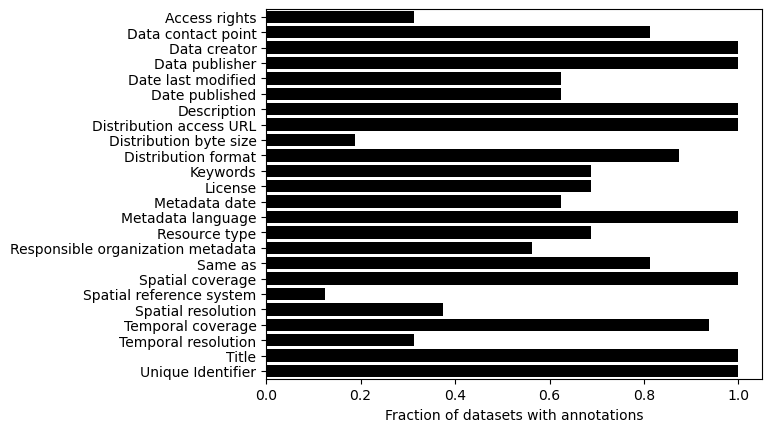

In [4]:
df_annot_present = pd.DataFrame({m: [labels_annot.get_text(url, m) != 'N/A' for url in labels_annot.keys()] for m in list_metadata_fields_ALL})
sns.barplot(data=df_annot_present, orient='h', errorbar=None, color='black')
plt.xlabel('Fraction of datasets with annotations')

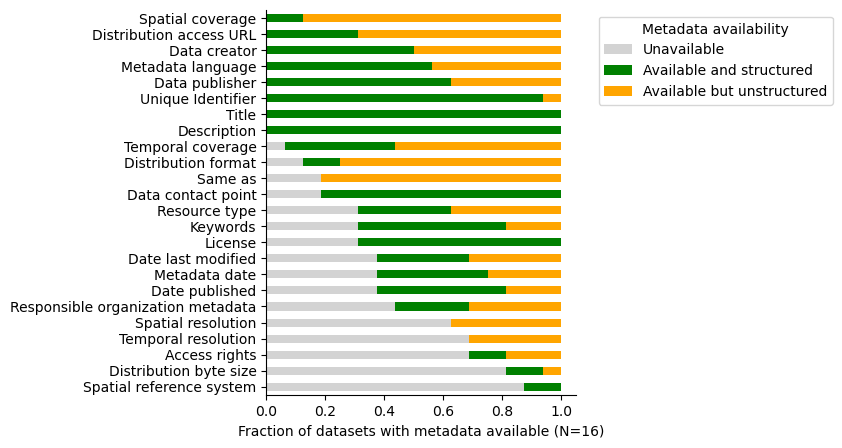

In [ ]:
save_fig = False

df_annot_present_fields = pd.DataFrame({m: [labels_annot.get_findability(url, m) for url in labels_annot.keys()] for m in list_metadata_fields_ALL})
df_annot_present_urls = pd.DataFrame({url: [labels_annot.get_findability(url, m) for m in list_metadata_fields_ALL] for url in labels_annot.keys()})

def tidy_up_findability(df):
    df = df.apply(lambda x: x.value_counts(normalize=True), axis=0).fillna(0)
    df = df.reindex([0, 1, 2], fill_value=0).T
    df = df.sort_values(by=[0, 1, 2], ascending=False)
    legend_dict = {0: 'Unavailable', 1: 'Available and structured', 2: 'Available but unstructured'}
    df = df.rename(columns=legend_dict)
    return df

df_annot_present_fields = tidy_up_findability(df_annot_present_fields)
df_annot_present_urls = tidy_up_findability(df_annot_present_urls)

fig, ax = plt.subplots(1, 1, figsize=(4, 5))
df_annot_present_fields.plot(kind='barh', stacked=True, color=['#d3d3d3', '#008000', '#ffa500'], ax=ax)
ax.set_xlabel(f'Fraction of datasets with metadata available (N={len(labels_annot)})')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Metadata availability')
despine(ax)
if save_fig:
    plt.savefig(os.path.join(fig_dir, 'metadata_availability.pdf'), bbox_inches='tight', dpi=300)

Text(50.7222222222222, 0.5, '')

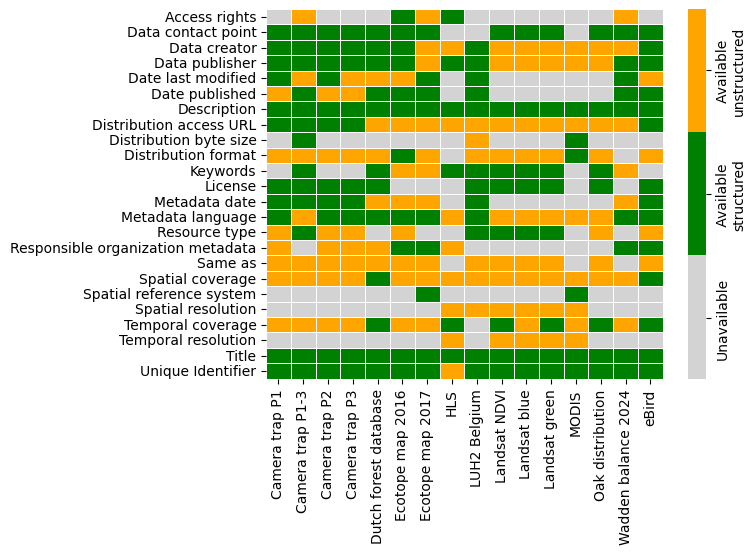

In [7]:
df_annot_present_full = {x: [] for x in ['metadata_field', 'findability', 'url', 'name', 'provider']}

for m in list_metadata_fields_ALL:
    for url in labels_annot.keys():
        df_annot_present_full['metadata_field'].append(m)
        df_annot_present_full['findability'].append(labels_annot.get_findability(url, m))
        df_annot_present_full['url'].append(url)
        df_annot_present_full['name'].append(url_to_acronym[url])
        # df_annot_present_full['provider'].append(labels_annot.get_provider(url))
        val = url_to_ds_name[url]
        provider = val.split('(')[-1].strip(')').strip()
        df_annot_present_full['provider'].append(provider)

## Create a discrete color palette for the heatmap
colors = ['#d3d3d3', '#008000', '#ffa500']
legend_dict = {0: 'Unavailable', 1: ' Available\nstructured', 2: '   Available\nunstructured'}
import matplotlib.colors as mcolors
cmap = mcolors.ListedColormap(colors)
# df_annot_present_full['findability'] = pd.Categorical(df_annot_present_full['findability'], categories=[0, 1, 2], ordered=True)


df_annot_present_full = pd.DataFrame(df_annot_present_full)
df_annot_present_full = df_annot_present_full.pivot_table(index='metadata_field', columns='name', values='findability')
sns.heatmap(df_annot_present_full, annot=False, fmt='.2f', cmap=cmap, 
            cbar_kws={'ticks': [0.33, 1, 1.67]}, linewidths=0.5)
## set ticklabels cbar
cbar = plt.gca().collections[0].colorbar
cbar.set_ticks([0.33, 1, 1.67])
cbar.set_ticklabels([legend_dict[0], legend_dict[1], legend_dict[2]], rotation=90, ha='left', va='center')
plt.xlabel('') 
plt.ylabel('')

## Evaluate all datasets:


In [19]:
test_llm_metrics = False
# fp_pred='outputs/2025-05-28/clean_entity_type_map.yaml'
# fp_pred='outputs/2025-06-03/cedar_openai_clean_entity_type_map.yaml'
folder_pred_croissant = 'outputs/2025-06-04/'
folder_pred_cedar = 'outputs/2025-06-06/'
fp_annot='outputs/annotations/ground_truth_metadata_annotations-2025-06-04.yaml'

cols_evaluation = ['llm_name', 'metadata_format', 'processing_stage', 'url', 'metadata_field', 'findability',  
                   'annot_missing', 'value_annot', 'value_pred',
                   'rouge', 'levenshtein']
llm_name_mapping = {'gemini': 'Gemini 2.5 Flash', 'openai': 'GPT4'}
postprocessing_mapping = {'clean': 'Post', 'initial': 'Pre'}
if test_llm_metrics:
    cols_evaluation += ['relevancy', 'faithfulness']
ds_scores = {x: [] for x in cols_evaluation}
count_it = 0
    
fp_pred_list = os.listdir(folder_pred_cedar) + [x for x in os.listdir(folder_pred_croissant) if x.startswith('croissant')]
for fp_pred in fp_pred_list:
    if not fp_pred.endswith('.yaml'):
        continue
    
    metadata_format_name = fp_pred.split('/')[-1].split('_')[0]
    llm_name = fp_pred.split('/')[-1].split('_')[1]
    processing_stage = fp_pred.split('/')[-1].split('_')[2]
    
    print(f"Evaluating predictions from {fp_pred} with LLM {llm_name} and metadata format {metadata_format_name}")
    if metadata_format_name == 'cedar':
        folder_pred = folder_pred_cedar
    elif metadata_format_name == 'croissant':
        folder_pred = folder_pred_croissant
    labels_annot, labels_pred, (list_ds_urls, list_metadata_fields) = uv.load_pred_and_annot(fp_pred=os.path.join(folder_pred, fp_pred), 
                                                                            fp_annot=fp_annot, keep_annotated_fields_only=True,
                                                                            metadata_format=metadata_format_name)

    if test_llm_metrics:
        list_metadata_fields = ['Description', 'Keywords']
        if llm_name == 'openai':
            continue 
        if processing_stage == 'initial':
            continue
        
    for col_evaluate in tqdm(list_metadata_fields):
        for url in list_ds_urls:
            count_it += 1
            ds_scores['url'].append(url)
            ds_scores['metadata_field'].append(col_evaluate)
            ds_scores['findability'].append(labels_annot.get_findability(url, col_evaluate))
            ds_scores['llm_name'].append(llm_name_mapping[llm_name])
            ds_scores['metadata_format'].append(metadata_format_name)
            ds_scores['processing_stage'].append(postprocessing_mapping[processing_stage])

            field_annot = labels_annot.get_text(url, col_evaluate)
            assert field_annot is not None, f"Field {col_evaluate} not found in annotations for URL {url}."
            field_pred = labels_pred.get_text(url, col_evaluate)
            if field_pred is None:
                field_pred = 'N/A'
        
            assert type(field_pred) is str, f"Field {col_evaluate} in predictions for URL {url} is not a string."
            assert type(field_annot) is str, f"Field {col_evaluate} in annotations for URL {url} is not a string."
            
            ds_scores['value_annot'].append(field_annot)
            ds_scores['value_pred'].append(field_pred)

            test_data = SingleTurnSample(
                user_input=f'What is the {col_evaluate} of this dataset?',
                response=field_pred,
                reference=field_annot,
                retrieved_contexts=labels_pred.context_lists[url]
            )

            if test_llm_metrics:
                faith_scorer = Faithfulness(llm=evaluator_llm)
                faith = await faith_scorer.single_turn_ascore(test_data)
                ds_scores['faithfulness'].append(faith)

            if field_annot == 'N/A':
                ds_scores['annot_missing'].append(True)
                if field_pred is None or field_pred.lower() in ['n/a', 'none', '', 'not specified', 'not available', 'not applicable', 'not provided', 'not given']:
                    # If both annotation and prediction are 'N/A', skip this dataset
                    ds_scores['rouge'].append(1)
                    ds_scores['levenshtein'].append(1)
                    if test_llm_metrics:
                        ds_scores['relevancy'].append(None)
                    continue
            else:
                ds_scores['annot_missing'].append(False)

            levenshtein_scorer = NonLLMStringSimilarity(distance_measure=DistanceMeasure.LEVENSHTEIN)
            levenshtein_sim = levenshtein_scorer.single_turn_score(test_data)
            ds_scores['levenshtein'].append(levenshtein_sim)

            rouge_scorer = RougeScore(rouge_type='rougeL', mode='fmeasure')
            rouge_score = rouge_scorer.single_turn_score(test_data)
            ds_scores['rouge'].append(rouge_score)

            if test_llm_metrics:
                rel_scorer = ResponseRelevancy(llm=evaluator_llm, embeddings=evaluator_embeddings)
                rel = await rel_scorer.single_turn_ascore(test_data)
                ds_scores['relevancy'].append(rel)


Evaluating predictions from cedar_openai_initial_entity_type_map.yaml with LLM openai and metadata format cedar
Loaded 16 annotations and predictions.


100%|██████████| 21/21 [00:00<00:00, 277.73it/s]


Evaluating predictions from cedar_gemini_initial_entity_type_map.yaml with LLM gemini and metadata format cedar
Loaded 16 annotations and predictions.


100%|██████████| 21/21 [00:00<00:00, 285.24it/s]


Evaluating predictions from cedar_gemini_clean_entity_type_map.yaml with LLM gemini and metadata format cedar
Loaded 16 annotations and predictions.


100%|██████████| 21/21 [00:00<00:00, 390.74it/s]


Evaluating predictions from cedar_openai_clean_entity_type_map.yaml with LLM openai and metadata format cedar
Loaded 16 annotations and predictions.


100%|██████████| 21/21 [00:00<00:00, 427.89it/s]


Evaluating predictions from croissant_gemini_clean_entity_type_map.yaml with LLM gemini and metadata format croissant
Loaded 16 annotations and predictions.


100%|██████████| 10/10 [00:00<00:00, 291.38it/s]


Evaluating predictions from croissant_openai_clean_entity_type_map.yaml with LLM openai and metadata format croissant
Loaded 16 annotations and predictions.


100%|██████████| 10/10 [00:00<00:00, 296.21it/s]


Evaluating predictions from croissant_gemini_initial_entity_type_map.yaml with LLM gemini and metadata format croissant
Loaded 16 annotations and predictions.


100%|██████████| 10/10 [00:00<00:00, 231.10it/s]


Evaluating predictions from croissant_openai_initial_entity_type_map.yaml with LLM openai and metadata format croissant
Loaded 16 annotations and predictions.


100%|██████████| 10/10 [00:00<00:00, 225.13it/s]


## Convert to dataframe

In [20]:
# df_scores.to_csv('outputs/llm_metrics_scores_2025-06-06-CEDAR_2025-06-04-CROISSANT.csv', index=False)

In [21]:

for url in ds_scores['url']:
    if url not in url_to_ds_name:
        print(f"URL {url} not found in url_to_ds_name mapping.")

ds_overview = {x: [] for x in ['Name', 'Provider', 'URL', 'Acronym']}
for url, val in url_to_ds_name.items():
    name, provider = val.split('(')
    name = name.strip()
    provider = provider.strip(')').strip()
    ds_overview['Name'].append(name)
    ds_overview['Provider'].append(provider)
    url_entry = r"\href{" + url + r"}{page}"
    if name == 'Ecotopenkaart 2016':
        url_entry += r", \href{https://datahuiswadden.openearth.nl/geonetwork/srv/api/records/A0h06_NlSEuNlium5OO3FA/formatters/xml}{xml}"
    ds_overview['URL'].append(url_entry)
    ds_overview['Acronym'].append(url_to_acronym[url])
df_overview = pd.DataFrame(ds_overview)
## sort by name provider 
df_overview = df_overview.sort_values(by=['Provider', 'Name']).reset_index(drop=True)

save_table = False
if save_table:
    df_overview.to_latex(os.path.join(fig_dir, 'dataset_overview.tex'), index=False, escape=False,
                         caption='Overview of datasets used in the evaluation.',
                         label='tab:dataset_overview')

In [46]:
ds_scores_clean = {k: v for k, v in ds_scores.items() if len(v) == count_it}  # Ensure all lists are of equal length
print(f'Dropped {len(ds_scores) - len(ds_scores_clean)} columns with missing values.')
df_scores = pd.DataFrame(ds_scores_clean)
df_scores['domain'] = df_scores['url'].apply(lambda x: x.lstrip('https://').lstrip('www.').split('/')[0])
df_scores['provider'] = df_scores['domain'].apply(lambda x: domain_to_provider[x])
df_scores['name'] = df_scores['url'].apply(lambda x: url_to_ds_name[x])
df_scores['metadata_format'] = df_scores['metadata_format'].apply(lambda x: {'cedar': 'LTER-LIFE', 'croissant': 'Croissant'}[x])
# df_scores.to_csv('outputs/2025-05-28/eval_clean_2025-06-02.csv', index=False)
assert all(df_scores[df_scores['findability'] == 0].annot_missing)

cols_df_scores = ['llm_name',
                'metadata_format',
                'processing_stage',
                'url',
                'domain',
                'provider',
                'name',
                'metadata_field',
                'findability',
                'annot_missing',
                'value_annot',
                'value_pred',
                'rouge',
                'levenshtein',
                ]
assert all([x in df_scores.columns for x in cols_df_scores]), f"Columns {cols_df_scores} not found in df_scores."
assert len(cols_df_scores) == len(df_scores.columns), f"Columns {cols_df_scores} not equal to df_scores columns."
df_scores = df_scores[cols_df_scores]

df_scores_present_structured = df_scores[df_scores['findability'] == 1].copy()
df_scores_present_unstructured = df_scores[df_scores['findability'] == 2].copy()
df_scores_missing = df_scores[df_scores['annot_missing'] == True].copy()

fields_fuzzy = ['Description', 'Keywords']
assert all([f in list_metadata_fields_ALL for f in fields_fuzzy]), f"Fields {fields_fuzzy} not found in metadata fields."
fields_exact = [f for f in list_metadata_fields_ALL if f not in fields_fuzzy]

df_scores_present_structured_exact = df_scores_present_structured[df_scores_present_structured['metadata_field'].isin(fields_exact)].copy()
df_scores_present_unstructured_exact = df_scores_present_unstructured[df_scores_present_unstructured['metadata_field'].isin(fields_exact)].copy()
df_scores_missing_exact = df_scores_missing[df_scores_missing['metadata_field'].isin(fields_exact)].copy()

df_scores_exact = df_scores[df_scores['metadata_field'].isin(fields_exact)].copy()
df_scores_present_exact = df_scores_exact[df_scores_exact['findability'] != 0].copy()


best_llm_name = 'Gemini 2.5 Flash'
df_scores_present_structured_best = df_scores_present_structured[np.logical_and(df_scores_present_structured['processing_stage'] == 'Post',
                                                                                df_scores_present_structured['llm_name'] == best_llm_name)].copy()
df_scores_present_unstructured_best = df_scores_present_unstructured[np.logical_and(df_scores_present_unstructured['processing_stage'] == 'Post',
                                                                                      df_scores_present_unstructured['llm_name'] == best_llm_name)].copy()
df_scores_missing_best = df_scores_missing[np.logical_and(df_scores_missing['processing_stage'] == 'Post',
                                                          df_scores_missing['llm_name'] == best_llm_name)].copy()

Dropped 0 columns with missing values.


In [ ]:
# df_scores['manual_score'] = -1
# df_scores
# # df_scores.to_excel('outputs/non-llm_metrics_scores_2025-06-06-CEDAR_2025-06-04-CROISSANT.xlsx', index=False)
# df_scores_tmp = pd.read_excel('outputs/non-llm_metrics_scores_2025-06-06-CEDAR_2025-06-04-CROISSANT__MANUALLY-CORRECTED.xlsx')
# df_scores_tmp

In [9]:
df_scores = pd.read_csv('outputs/llm_metrics_scores_2025-06-06-CEDAR_2025-06-04-CROISSANT.csv')
df_scores['metadata_format'] = df_scores['metadata_format'].apply(lambda x: {'cedar': 'LTER-LIFE', 'croissant': 'Croissant'}[x])

test_llm_metrics = True
df_scores 

,llm_name,metadata_format,processing_stage,url,metadata_field,findability,annot_missing,value_annot,value_pred,rouge,levenshtein,relevancy,faithfulness,domain,provider,name,Metadata availability
0,Gemini 2.5 Flash,LTER-LIFE,Post,https://datahuiswadden.openearth.nl/geonetwork...,Description,1,False,For the proper management of areas such as the...,Ecotopenkaart Waddenzee volgens de ZES.1 Typol...,0.000000,0.048751,0.000000,1.000000,datahuiswadden.openearth.nl,Datahuis Wadden,Ecotopenkaart 2016 (Datahuis Wadden),Available and structured
1,Gemini 2.5 Flash,LTER-LIFE,Post,https://datahuiswadden.openearth.nl/geonetwork...,Description,1,False,"The three Wadden provinces – North Holland, Fr...",Waddenbalans 2024 Description,0.014706,0.031579,0.000000,1.000000,datahuiswadden.openearth.nl,Datahuis Wadden,Waddenbalans 2024 (Datahuis Wadden),Available and structured
2,Gemini 2.5 Flash,LTER-LIFE,Post,https://datahuiswadden.openearth.nl/geonetwork...,Description,1,False,"An ecotope is an ecomorphological, landscape m...","Een ecotoop is een ecomorfologische, landschap...",0.025316,0.124528,0.756644,1.000000,datahuiswadden.openearth.nl,Datahuis Wadden,Ecotopenkaart 2017 (Datahuis Wadden),Available and structured
3,Gemini 2.5 Flash,LTER-LIFE,Post,https://developers.google.com/earth-engine/dat...,Description,1,False,The Harmonized Landsat Sentinel-2 (HLS) projec...,Harmonized Landsat Sentinel-2 (HLS) project. T...,0.246753,0.180068,0.800727,1.000000,developers.google.com,Google Earth Engine,Harmonized Landsat Sentinel-2 (Google Earth En...,Available and structured
4,Gemini 2.5 Flash,LTER-LIFE,Post,https://lifesciences.datastations.nl/dataset.x...,Description,1,False,The Dutch forest reserves network encompasses ...,Dutch Forest Reserves Network Database. This d...,0.237288,0.243478,0.821969,1.000000,lifesciences.datastations.nl,DANS Datastations,Dutch forest reserves database and network (DANS),Available and structured
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,Gemini 2.5 Flash,Croissant,Post,https://www.gbif.org/dataset/74196cd9-7ebc-4b2...,Keywords,0,True,NaN,"Camera Trap Data, Amsterdamse Waterleidingduin...",0.000000,0.015385,0.000000,1.000000,gbif.org,GBIF,Waterleidingduinen camera trap P1 (GBIF),Unavailable
60,Gemini 2.5 Flash,Croissant,Post,https://www.gbif.org/dataset/f9ba3c2e-0636-4f6...,Keywords,0,True,NaN,"Camera Trap, Amsterdamse Waterleidingduinen, B...",0.000000,0.014286,0.000000,1.000000,gbif.org,GBIF,Waterleidingduinen camera trap P2 (GBIF),Unavailable
61,Gemini 2.5 Flash,Croissant,Post,https://www.gbif.org/dataset/bc0acb9a-131f-408...,Keywords,0,True,NaN,"Camera Trap, Amsterdamse Waterleidingduinen, P...",0.000000,0.017241,0.000000,1.000000,gbif.org,GBIF,Waterleidingduinen camera trap P3 (GBIF),Unavailable
62,Gemini 2.5 Flash,Croissant,Post,https://zenodo.org/records/11440456,Keywords,1,False,"ecology, camera trapping, dunes","Ecology, Camera Trapping, Dunes",1.000000,0.870968,0.778517,1.000000,zenodo.org,Zenodo,Waterleidingduinen camera trap P1-3 (Zenodo),Available and structured


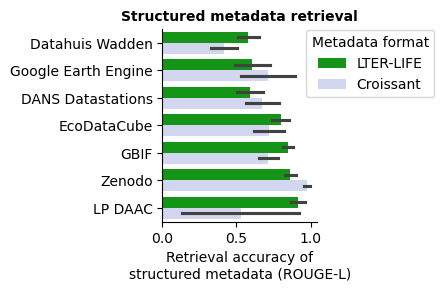

In [23]:
save_fig = False

fig, ax = plt.subplots(1, 1, figsize=(2, 2.5))

sns.barplot(data=df_scores_present_structured_exact[df_scores_present_structured_exact['processing_stage'] == 'Post'], 
            x='rouge', y='provider', hue='metadata_format', orient='h', errorbar='se', ax=ax,
            palette=["#00aa03", "#cdd4f4"])
ax.set_ylabel('')
ax.set_xlabel('Retrieval accuracy of\nstructured metadata (ROUGE-L)')
despine(ax)
ax.set_title('Structured metadata retrieval', fontsize=10, fontweight='bold')
ax.legend(title='Metadata format', loc='upper right', bbox_to_anchor=(1.8, 1.03))

if save_fig:
    plt.savefig(os.path.join(fig_dir, 'metadata_retrieval_structured_summary.pdf'), bbox_inches='tight', dpi=300)

In [309]:
df_scores_present_structured_exact[np.logical_and(df_scores_present_structured_exact['processing_stage'] == 'Post',
                                                  df_scores_present_structured_exact['provider'] == 'Datahuis Wadden')][['metadata_format', 'metadata_field', 'rouge', 'value_pred', 'value_annot']][:40]

,metadata_format,metadata_field,rouge,value_pred,value_annot
672,cedar,Access rights,0.400000,Copyright,"Copyright, no user limitations"
688,cedar,Data contact point,1.000000,Wageningen Marine Research,Wageningen Marine Research
689,cedar,Data contact point,0.727273,info@hetpon-telos.nl,"Het PON & Telos, info@hetpon-telos.nl"
690,cedar,Data contact point,0.888889,servicedesk-data@rws.nl,"Rijkswaterstaat, servicedesk-data@rws.nl"
704,cedar,Data creator,1.000000,Wageningen Marine Research,Wageningen Marine Research
720,cedar,Data publisher,0.000000,Wageningen Marine Research,Datahuis Wadden
721,cedar,Data publisher,0.000000,Het PON & Telos,Datahuis Wadden
784,cedar,Distribution format,0.571429,gml+xml,gml+xml ( 3.2.1 )
848,cedar,Metadata language,0.000000,Nederlands; Vlaams,"Dutch, Flemish"
849,cedar,Metadata language,0.000000,N/A,Dutch


/var/folders/kh/y9z_055x6gq8gc74b6y16r1c0000gn/T/ipykernel_6940/1670291949.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(yticklabels)  # Set y-tick labels for the first subplot
/var/folders/kh/y9z_055x6gq8gc74b6y16r1c0000gn/T/ipykernel_6940/1670291949.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(['' for _ in yticklabels_1])  # Remove y-tick labels from the second subplot
/var/folders/kh/y9z_055x6gq8gc74b6y16r1c0000gn/T/ipykernel_6940/1670291949.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2].set_yticklabels(['' for _ in yticklabels_2])  # Remove y-tick labels from the third subplot
/var/folders/kh/y9z_055x6gq8gc74b6y16r1c0000gn/T/ipykernel_6940/1670291949.py:56: UserWar

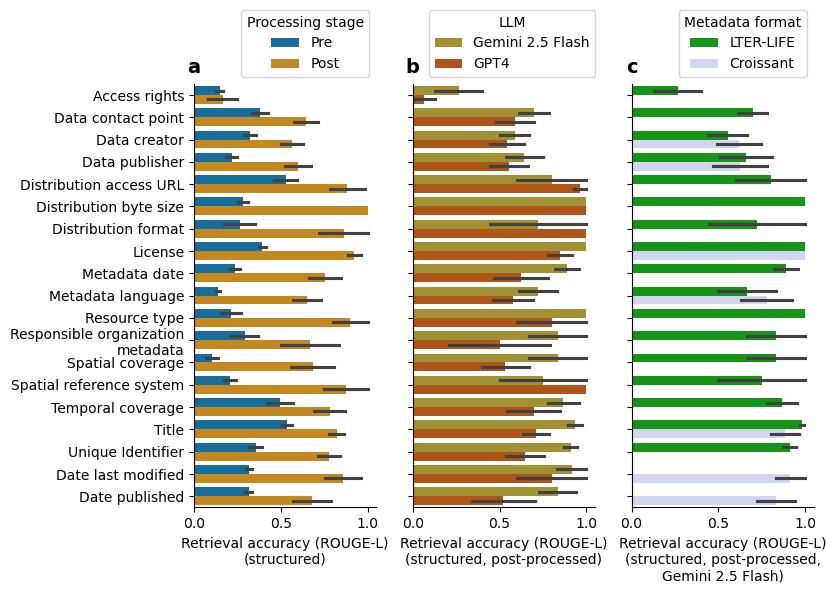

In [14]:
save_fig = True

fig, ax = plt.subplots(1, 3, figsize=(8, 5.5))

sns.barplot(data=df_scores_present_structured_exact, x='rouge', y='metadata_field', 
            hue='processing_stage', orient='h', errorbar='se', ax=ax[0])
ax[0].set_ylabel('')
ax[0].set_xlabel('Retrieval accuracy (ROUGE-L)\n(structured)')
despine(ax[0])
ax[0].legend(title='Processing stage', loc='lower right', bbox_to_anchor=(1, 1))
# ax[0].set_title('Post-processing improves accuracy', fontsize=10, fontweight='bold')
# ax[0].legend(title='Processing stage', loc='upper right', bbox_to_anchor=(1.15, 1))

sns.barplot(data=df_scores_present_structured_exact[df_scores_present_structured_exact['processing_stage'] == 'Post'], 
            x='rouge', y='metadata_field', hue='llm_name', 
            orient='h', errorbar='se', ax=ax[1],
            palette=["#b49e1f", "#c75000"])  
ax[1].set_ylabel('')
ax[1].set_xlabel('Retrieval accuracy (ROUGE-L)\n(structured, post-processed)')
despine(ax[1])
ax[1].legend(title='LLM', loc='lower right', bbox_to_anchor=(1.04, 1))
# ax[1].set_title('Comparison LLMs', fontsize=10, fontweight='bold')
# ax[1].legend(title='LLM', loc='upper right', bbox_to_anchor=(1.15, 1))



## Test differences between metadata formats
sel_llm_name = 'Gemini 2.5 Flash'
df_use = df_scores_present_structured_exact[np.logical_and(df_scores_present_structured_exact['processing_stage'] == 'Post',
                                                           df_scores_present_structured_exact['llm_name'] == sel_llm_name)]
# df_use = df_scores_present_structured_exact[df_scores_present_structured_exact['processing_stage'] == 'Post']
sns.barplot(data=df_use, 
            x='rouge', y='metadata_field', hue='metadata_format', 
            orient='h', errorbar='se', ax=ax[2],
            palette=["#00aa03", "#cdd4f4"])  
ax[2].set_ylabel('')
ax[2].set_xlabel(f'Retrieval accuracy (ROUGE-L)\n(structured, post-processed,\n{sel_llm_name})')
despine(ax[2])
ax[2].legend(title='Metadata format', loc='lower right', bbox_to_anchor=(1, 1))
# ax[2].set_title('Comparison metadata formats', fontsize=10, fontweight='bold')
# ax[2].legend(title='Metadata format', loc='upper right', bbox_to_anchor=(1.3, 1))

## assert yticklabels are the same for both subplots
yticklabels_0 = [t.get_text() for t in ax[0].get_yticklabels()]
yticklabels_1 = [t.get_text() for t in ax[1].get_yticklabels()]
yticklabels_2 = [t.get_text() for t in ax[2].get_yticklabels()]
assert yticklabels_0 == yticklabels_1, f"Y-tick labels are not the same: {yticklabels_0} != {yticklabels_1}"
assert yticklabels_0 == yticklabels_2, f"Y-tick labels are not the same: {yticklabels_0} != {yticklabels_2}"
yticklabels = [y  if y != 'Responsible organization metadata' else 'Responsible organization\nmetadata' for y in yticklabels_0]
ax[0].set_yticklabels(yticklabels)  # Set y-tick labels for the first subplot
ax[1].set_yticklabels(['' for _ in yticklabels_1])  # Remove y-tick labels from the second subplot
ax[2].set_yticklabels(['' for _ in yticklabels_2])  # Remove y-tick labels from the third subplot
# ax[2].set_title('Comparison metadata formats', fontsize=10, fontweight='bold')

for iplot, letter in enumerate(['a', 'b', 'c']):
    ax[iplot].annotate(letter, xy=(0.0, 1.04), textcoords='axes fraction',
                fontsize=14, fontweight='bold', ha='center', va='center',
                clip_on=False, zorder=10)

if save_fig:
    plt.savefig(os.path.join(fig_dir, 'metadata_retrieval_accuracy.pdf'), bbox_inches='tight', dpi=300)


In [11]:
# ## Two way ANOVA on ROUGE score with LLM and metadata field as factors
# from statsmodels.formula.api import ols, mixedlm
# import statsmodels.api as sm

# df_use = df_scores_present_structured_exact[df_scores_present_structured['processing_stage'] == 'Post']

# model = ols('rouge ~ C(llm_name) + C(metadata_field) + C(llm_name):C(metadata_field)', data=df_use).fit()
# anova_table = sm.stats.anova_lm(model, typ=2)
# print(anova_table)

# ## Mixed effects model:
# model = mixedlm('rouge ~ C(llm_name)', data=df_use, groups=df_use['metadata_field']).fit()
# print(model.summary())


In [15]:
import statsmodels.formula.api as smf
from scipy import stats          # only for a manual check

sel_llm_name = 'Gemini 2.5 Flash'
sel_llm_name = 'GPT4'
df_use = df_scores_present_structured_exact[np.logical_and(df_scores_present_structured['processing_stage'] == 'Post',
                                                           df_scores_present_structured['llm_name'] == sel_llm_name)]

def likelihood_ratio_test(df, col_fixed, col_random, col_score='rouge', verbose=1):
    ## Fit full model (fixed + random effects)
    m_full  = smf.mixedlm(f'{col_score} ~ C({col_fixed})',
                        data=df,
                        groups=df[col_random],)
    res_full = m_full.fit(reml=False) # reml=False to use Maximum Likelihood (ML) estimation

    ## Null model: only random effect
    m_null  = smf.mixedlm(f'{col_score} ~ 1',
                        data=df,
                        groups=df[col_random],)
    res_null = m_null.fit(reml=False)

    ## Test:
    lr = 2 * (res_full.llf - res_null.llf)  # 2x the likelihood ratio is distributed as a chi-squared distribution under null hypothesis
    df_diff = res_full.df_modelwc - res_null.df_modelwc  # degrees of freedom difference
    p_value = stats.chi2.sf(lr, df_diff)  # p-value from the chi-squared distribution

    if verbose:
        print(f"LR test for {col_fixed}, controlled for {col_random}: χ² = {lr:.2f},  df = {df_diff},   p = {p_value:}")
    return lr, df_diff, p_value

## Test pre vs post processing
likelihood_ratio_test(df_scores_present_structured_exact, col_fixed='processing_stage', col_random='metadata_field', col_score='rouge')

## Test differences between providers
for sel_llm_name in ['Gemini 2.5 Flash', 'GPT4']:
    print(f"Testing differences between providers for {sel_llm_name}")
    df_use = df_scores_present_structured_exact[np.logical_and(df_scores_present_structured['processing_stage'] == 'Post',
                                                            df_scores_present_structured['llm_name'] == sel_llm_name)]
    likelihood_ratio_test(df_use, col_fixed='provider', col_random='metadata_field', col_score='rouge')

## Test differences between LLMs
df_use = df_scores_present_structured_exact[df_scores_present_structured_exact['processing_stage'] == 'Post']
likelihood_ratio_test(df_use, col_fixed='llm_name', col_random='metadata_field', col_score='rouge')
# likelihood_ratio_test(df_use, col_fixed='metadata_format', col_random='metadata_field', col_score='rouge')

## Test differences between metadata formats
sel_llm_name = 'Gemini 2.5 Flash'
df_use = df_scores_present_structured_exact[np.logical_and(df_scores_present_structured_exact['processing_stage'] == 'Post',
                                                           df_scores_present_structured_exact['llm_name'] == sel_llm_name)]
df_tmp = df_use[['metadata_format', 'metadata_field']].groupby(['metadata_format', 'metadata_field']).size().reset_index(name='count')
list_fields_both = []
for mf in df_tmp['metadata_field'].unique():
    if len(df_tmp[df_tmp['metadata_field'] == mf]) == 2:  # if the field exists for both metadata formats
        list_fields_both.append(mf)
print(f"Fields that exist for both metadata formats: {list_fields_both}: {len(list_fields_both)}/{len(df_tmp['metadata_field'].unique())}")
df_use = df_use[df_use['metadata_field'].isin(list_fields_both)]
likelihood_ratio_test(df_use, col_fixed='metadata_format', col_random='metadata_field', col_score='rouge')

## Test differences between structured and unstructured metadata
sel_llm_name = 'Gemini 2.5 Flash'
df_use = df_scores_present_exact[np.logical_and(df_scores_present_exact['processing_stage'] == 'Post',
                                                df_scores_present_exact['llm_name'] == sel_llm_name)]
df_tmp = df_use[['findability', 'metadata_field']].groupby(['findability', 'metadata_field']).size().reset_index(name='count')
list_fields_both = []
for mf in df_tmp['metadata_field'].unique():
    if len(df_tmp[df_tmp['metadata_field'] == mf]) == 2:  # if the field exists for both metadata formats
        list_fields_both.append(mf)
print(f"Fields that exist for both findabilities: {list_fields_both}: {len(list_fields_both)}/{len(df_tmp['metadata_field'].unique())}")
df_use = df_use[df_use['metadata_field'].isin(list_fields_both)]
likelihood_ratio_test(df_use, col_fixed='findability', col_random='metadata_field', col_score='rouge')

/var/folders/kh/y9z_055x6gq8gc74b6y16r1c0000gn/T/ipykernel_95630/1549678291.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_use = df_scores_present_structured_exact[np.logical_and(df_scores_present_structured['processing_stage'] == 'Post',
/opt/anaconda3/envs/metaharv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/envs/metaharv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/var/folders/kh/y9z_055x6gq8gc74b6y16r1c0000gn/T/ipykernel_95630/1549678291.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_use = df_scores_present_structured_exact[np.logical_and(df_scores_present_structured['processing_stage'] ==

LR test for processing_stage, controlled for metadata_field: χ² = 276.44,  df = 1,   p = 4.475741130331323e-62
Testing differences between providers for Gemini 2.5 Flash
LR test for provider, controlled for metadata_field: χ² = 28.09,  df = 6,   p = 9.032691019526217e-05
Testing differences between providers for GPT4


/opt/anaconda3/envs/metaharv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/metaharv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/envs/metaharv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 1.096224
  warnings.warn(msg, ConvergenceWarning)
/var/folders/kh/y9z_055x6gq8gc74b6y16r1c0000gn/T/ipykernel_95630/1549678291.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_use = df_scores_present_structured_exact[np.logical_and(df_scores_present_structured['processing_stage'] == 'Post',
/opt/anaconda3/envs/meta

LR test for provider, controlled for metadata_field: χ² = 35.53,  df = 6,   p = 3.4000228643841726e-06
LR test for llm_name, controlled for metadata_field: χ² = 15.90,  df = 1,   p = 6.689159145040785e-05
Fields that exist for both metadata formats: ['Data creator', 'Data publisher', 'License', 'Metadata language', 'Title']: 5/19
LR test for metadata_format, controlled for metadata_field: χ² = 0.01,  df = 1,   p = 0.9117318356975592
Fields that exist for both findabilities: ['Access rights', 'Data creator', 'Data publisher', 'Date last modified', 'Date published', 'Distribution access URL', 'Distribution byte size', 'Distribution format', 'Metadata date', 'Metadata language', 'Resource type', 'Responsible organization metadata', 'Spatial coverage', 'Temporal coverage', 'Unique Identifier']: 15/22
LR test for findability, controlled for metadata_field: χ² = 0.02,  df = 1,   p = 0.8842629392129395


(np.float64(0.021189855263401114), 1, np.float64(0.8842629392129395))

/var/folders/kh/y9z_055x6gq8gc74b6y16r1c0000gn/T/ipykernel_95630/2625097493.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_use['findability'] = df_use['findability'].apply(lambda x: 'Available and structured' if x == 1 else 'Available but unstructured')
/var/folders/kh/y9z_055x6gq8gc74b6y16r1c0000gn/T/ipykernel_95630/2625097493.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels, rotation=45, ha='right')


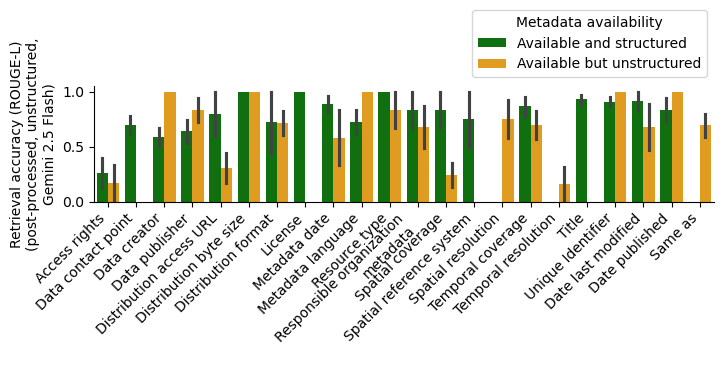

In [ ]:
save_fig = False

fig, ax = plt.subplots(1, 1, figsize=(8, 1.5))

sel_llm_name = 'Gemini 2.5 Flash'
df_use = df_scores_present_exact[np.logical_and(df_scores_present_exact['processing_stage'] == 'Post',
                                                df_scores_present_exact['llm_name'] == sel_llm_name)]
# df_use = df_scores_present_exact[df_scores_present_exact['processing_stage'] == 'Post']
df_use['findability'] = df_use['findability'].apply(lambda x: 'Available and structured' if x == 1 else 'Available but unstructured')
sns.barplot(data=df_use, 
            # x='rouge', y='metadata_field', hue='findability', orient='h', errorbar='se', ax=ax,
            x='metadata_field', y='rouge', hue='findability', orient='v', errorbar='se', ax=ax,
            palette=['#008000', '#ffa500'])  
ax.set_xlabel('')
ax.set_ylabel(f'Retrieval accuracy (ROUGE-L)\n(post-processed, unstructured,\n{sel_llm_name})')
despine(ax)
ax.legend(title='Metadata availability', loc='lower right', bbox_to_anchor=(1, 1.02))
xticklabels = [y  if y.get_text() != 'Responsible organization metadata' else 'Responsible organization\nmetadata' for y in ax.get_xticklabels()]
ax.set_xticklabels(xticklabels, rotation=45, ha='right')

if save_fig:
    plt.savefig(os.path.join(fig_dir, 'metadata_unstructured_retrieval_accuracy.pdf'), bbox_inches='tight', dpi=300)


In [487]:
df_use[df_use['metadata_field'] == 'Distribution access URL']

,llm_name,metadata_format,processing_stage,url,metadata_field,findability,annot_missing,value_annot,value_pred,rouge,levenshtein,domain,provider,name
752,Gemini 2.5 Flash,cedar,Post,https://datahuiswadden.openearth.nl/geonetwork...,Distribution access URL,Available but unstructured,False,https://viewer.openearth.nl/wadden-viewer/down...,WWW:LINK-1.0-http--link,0.125000,0.078947,datahuiswadden.openearth.nl,Datahuis Wadden,Ecotopenkaart 2016 (Datahuis Wadden)
753,Gemini 2.5 Flash,cedar,Post,https://datahuiswadden.openearth.nl/geonetwork...,Distribution access URL,Available but unstructured,False,https://www.investeringskaderwaddengebied.nl/w...,https://www.investeringskaderwaddengebied.nl/w...,1.000000,1.000000,datahuiswadden.openearth.nl,Datahuis Wadden,Waddenbalans 2024 (Datahuis Wadden)
754,Gemini 2.5 Flash,cedar,Post,https://datahuiswadden.openearth.nl/geonetwork...,Distribution access URL,Available but unstructured,False,https://viewer.openearth.nl/wadden-viewer/down...,https://viewer.openearth.nl/wadden-viewer/down...,1.000000,1.000000,datahuiswadden.openearth.nl,Datahuis Wadden,Ecotopenkaart 2017 (Datahuis Wadden)
755,Gemini 2.5 Flash,cedar,Post,https://developers.google.com/earth-engine/dat...,Distribution access URL,Available but unstructured,False,https://doi.org/10.5067/HLS/HLSS30.002,"ee.ImageCollection(""NASA/HLS/HLSS30/v002"")",0.285714,0.357143,developers.google.com,Google Earth Engine,Harmonized Landsat Sentinel-2 (Google Earth En...
756,Gemini 2.5 Flash,cedar,Post,https://lifesciences.datastations.nl/dataset.x...,Distribution access URL,Available but unstructured,False,https://doi.org/10.17026/dans-2bd-kskz,https://doi.org/10.17026/dans-2bd-kskz,1.000000,1.000000,lifesciences.datastations.nl,DANS Datastations,Dutch forest reserves database and network (DANS)
757,Gemini 2.5 Flash,cedar,Post,https://lpdaac.usgs.gov/products/mod09a1v061/,Distribution access URL,Available but unstructured,False,"https://e4ftl01.cr.usgs.gov/MOLT/MOD09A1.061/,...",LP DAAC Data Pool,0.000000,0.040359,lpdaac.usgs.gov,LP DAAC,MODIS Terra MOD09A1 Version 6.1 (LP DAAC)
758,Gemini 2.5 Flash,cedar,Post,https://stac.ecodatacube.eu/blue_glad.landsat....,Distribution access URL,Available but unstructured,False,https://doi.org/10.5281/zenodo.10851081,N/A,0.000000,0.025641,ac.ecodatacube.eu,EcoDataCube,Cloud-free reconstructed Landsat yearly blue b...
759,Gemini 2.5 Flash,cedar,Post,https://stac.ecodatacube.eu/green_glad.landsat...,Distribution access URL,Available but unstructured,False,https://doi.org/10.5281/zenodo.10851081,N/A,0.000000,0.025641,ac.ecodatacube.eu,EcoDataCube,Cloud-free reconstructed Landsat yearly green ...
760,Gemini 2.5 Flash,cedar,Post,https://stac.ecodatacube.eu/ndvi_glad.landsat....,Distribution access URL,Available but unstructured,False,https://doi.org/10.5281/zenodo.10884235,Not Explicitly Stated,0.000000,0.102564,ac.ecodatacube.eu,EcoDataCube,Cloud-free reconstructed Landsat bimonthly NDV...
761,Gemini 2.5 Flash,cedar,Post,https://stac.ecodatacube.eu/veg_quercus.robur_...,Distribution access URL,Available but unstructured,False,https://doi.org/10.5281/zenodo.5887415,N/A,0.000000,0.026316,ac.ecodatacube.eu,EcoDataCube,Actual probability distribution for Quercus ro...


In [488]:
df_use[np.logical_and(df_use['metadata_field'] == 'Distribution access URL', df_use['provider'] == 'Datahuis Wadden')].rouge.mean()

np.float64(0.7083333333333334)

In [16]:
save_table = False
dict_not_found = {x: []  for x in ['llm_name', 'metadata_format_name', 'fraction_not_found', 'Metadata availability']}

for sel_llm_name in llm_name_mapping.values():
    sel_metadata_format_name = None
    df_scores_present_structured_sel = df_scores_present_structured[np.logical_and(df_scores_present_structured['processing_stage'] == 'Post',
                                                                                    df_scores_present_structured['llm_name'] == sel_llm_name)].copy()
    df_scores_present_unstructured_sel = df_scores_present_unstructured[np.logical_and(df_scores_present_unstructured['processing_stage'] == 'Post',
                                                                                        df_scores_present_unstructured['llm_name'] == sel_llm_name)].copy()
    df_scores_missing_sel = df_scores_missing[np.logical_and(df_scores_missing['processing_stage'] == 'Post',
                                                            df_scores_missing['llm_name'] == sel_llm_name)].copy()


    for df_name, df_tmp in zip(['Available and structured metadata not retrieved (FN, $\%$)', 'Available but unstructured metadata not recognised (FN, $\%$)', 'Unavailable metadata reported as unavailable (TN, $\%$)'], [df_scores_present_structured_sel, df_scores_present_unstructured_sel, df_scores_missing_sel]):
        ## reported missing?
        list_missing_names = ['N/A', 'Not specified', 'Not available', 'Not applicable', 
                              'Not provided', 'Not given', 'Not specified in the text',
                              'Not Explicitly Stated', 'Not explicitly defined', 
                              'Not explicitly stated', 'Not Specified In Text',
                              'Not Specified', 'Not explicitly detailed']
        tp = len(df_tmp[(df_tmp['annot_missing'] == True) & (df_tmp['value_pred'].isin(list_missing_names))])
        fn = len(df_tmp[(df_tmp['annot_missing'] == True) & (~ df_tmp['value_pred'].isin(list_missing_names))])
        fp = len(df_tmp[(df_tmp['annot_missing'] == False) & (df_tmp['value_pred'].isin(list_missing_names))])
        tn = len(df_tmp[(df_tmp['annot_missing'] == False) & (~ df_tmp['value_pred'].isin(list_missing_names))])

        assert tp == 0 or tn == 0, f"TP and TN cannot both be non-zero: TP={tp}, TN={tn} for {df_name}."
        fraction_not_found = (tp + fp) / (tp + fp + tn + fn)
        dict_not_found['llm_name'].append(sel_llm_name)
        dict_not_found['metadata_format_name'].append(sel_metadata_format_name if sel_metadata_format_name is not None else 'both')
        dict_not_found['fraction_not_found'].append(fraction_not_found * 100)
        dict_not_found['Metadata availability'].append(df_name)
        # print(f"{df_name}:\n"
        #         f"True positives (TP): {tp}\n"
        #         f"False negatives (FN): {fn}\n"
        #         f"False positives (FP): {fp}\n"
        #         f"True negatives (TN): {tn}\n"
        #         f"Precision: {tp / (tp + fp) if tp + fp > 0 else 0:.2f}\n"
        #         f"Recall: {tp / (tp + fn) if tp + fn > 0 else 0:.2f}\n"
        #         f"F1-score: {2 * tp / (2 * tp + fp + fn) if 2 * tp + fp + fn > 0 else 0:.2f}\n",
        #         f"Fraction positive: {(tp + fp) / (tp + fp + tn + fn):.2f}\n")

df_not_found = pd.DataFrame(dict_not_found)
df_not_found['fraction_not_found'] = df_not_found['fraction_not_found'].round(1)
df_not_found = df_not_found.pivot_table(index='Metadata availability', columns='llm_name', values='fraction_not_found')

if save_table:
    ## save to tex 
    df_not_found.to_latex(os.path.join(fig_dir, 'metadata_not_found.tex'), 
                          float_format="%.1f", 
                          column_format='l' + 'c' * len(df_not_found.columns),
                          caption=r"Fraction of metadata fields that were not identified by the LLMs. For available metadata, this includes structured fields that were not retrieved and unstructured fields that were not recognised (false negatives (FN)) . For unavailable metadata, this includes fields that were reported as unavailable (true negatives (TN)). Post-processed results for both CEDAR and Croissant formats were used.",
                          label='tab:metadata_not_found',
                          escape=False,
                          index=True)
    

df_not_found

llm_name,GPT4,Gemini 2.5 Flash
Metadata availability,,
"Available and structured metadata not retrieved (FN, $\%$)",12.5,0.0
"Available but unstructured metadata not recognised (FN, $\%$)",21.2,6.2
"Unavailable metadata reported as unavailable (TN, $\%$)",56.8,34.7


In [18]:
sel_llm_name = 'Gemini 2.5 Flash'
df_scores_missing_sel = df_scores_missing[np.logical_and(df_scores_missing['processing_stage'] == 'Post',
                                                            df_scores_missing['llm_name'] == sel_llm_name)].copy()
df_scores_missing_sel = df_scores_missing_sel[(df_scores_missing_sel['annot_missing'] == True) & (~ df_scores_missing_sel['value_pred'].isin(list_missing_names))][['name', 'metadata_field', 'value_pred', 'value_annot']]

print(f'{sel_llm_name} found {len(df_scores_missing_sel)} fields with missing annotations.')
df_scores_missing_sel[40:]

Gemini 2.5 Flash found 77 fields with missing annotations.


,name,metadata_field,value_pred,value_annot
929,Waddenbalans 2024 (Datahuis Wadden),Spatial resolution,Municipal Level,N/A
930,Ecotopenkaart 2017 (Datahuis Wadden),Spatial resolution,Not explicitly stated (implied by mappable units),N/A
932,Dutch forest reserves database and network (DANS),Spatial resolution,"Reserve Level, One Ha Rectangular Core Area, C...",N/A
938,eBird observation dataset (GBIF),Spatial resolution,Not Explicitly Specified,N/A
942,Waterleidingduinen camera trap P1-3 (Zenodo),Spatial resolution,"Not explicitly stated, implied by exact camera...",N/A
959,Downscaled LUH2 land use scenarios for Belgium...,Temporal coverage,Present to 2050,N/A
961,Waddenbalans 2024 (Datahuis Wadden),Temporal resolution,Annual,N/A
962,Ecotopenkaart 2017 (Datahuis Wadden),Temporal resolution,Annual,N/A
969,Actual probability distribution for Quercus ro...,Temporal resolution,"Multi-Year Segments (e.g., 2000-2002, 2002-2006)",N/A
970,eBird observation dataset (GBIF),Temporal resolution,Not Explicitly Specified,N/A


In [21]:
df_scores.groupby(['metadata_format', 'metadata_field']).size().reset_index(name='count').sort_values(by='count', ascending=False)

,metadata_format,metadata_field,count
0,cedar,Access rights,64
16,cedar,Spatial resolution,64
29,croissant,Same as,64
28,croissant,Metadata language,64
27,croissant,License,64
26,croissant,Keywords,64
25,croissant,Description,64
24,croissant,Date published,64
23,croissant,Date last modified,64
22,croissant,Data publisher,64
